In [31]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import statsmodels.api as sm
import statsmodels.datasets
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge, Ridge, LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import set_config

import warnings
warnings.filterwarnings('ignore')

In [2]:
%run pandas-missing-extension.ipynb

In [3]:
nhanes_raw_df = nhanes.load.load_NHANES_data(year='2017-2018').clean_names(case_type='snake')
nhanes_raw_df.head()

,general_health_condition,ever_breastfed_or_fed_breastmilk,age_stopped_breastfeedingdays,age_first_fed_formuladays,age_stopped_receiving_formuladays,age_started_other_foodbeverage,age_first_fed_milkdays,type_of_milk_first_fed_whole_milk,type_of_milk_first_fed2_milk,type_of_milk_first_fed1_milk,...,days_smoked_cigs_during_past30_days,avg_cigarettesday_during_past30_days,tried_to_quit_smoking,times_stopped_smoking_cigarettes,how_long_were_you_able_to_stop_smoking,unit_of_measure_dayweekmonthyear_2_smq,current_selfreported_height_inches,current_selfreported_weight_pounds,tried_to_lose_weight_in_past_year,times_lost10_lbs_or_more_to_lose_weight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
nhanes_grupo_3 = nhanes_raw_df.select_columns('total_number_of_people_in_the_family',
                                              'age_in_years_at_screening',
                                              'gender',
                                              'taking_insulin_now',
                                              'weight_kg',
                                              'standing_height_cm',
                                              'blood_mercury_total_ugl',
                                              'total_monounsaturated_fatty_acids_gm_dr1_tot',
                                              'systolic_blood_pres3_rd_rdg_mm_hg',
                                              'carbohydrate_gm_dr2_tot',
                                              'waist_circumference_cm',
                                              'general_health_condition',).rename_columns({'total_number_of_people_in_the_family': 'family_size',
                                                                                            'age_in_years_at_screening': 'age',
                                                                                            'taking_insulin_now': 'insulin',
                                                                                            'weight_kg': 'weight',
                                                                                            'standing_height_cm': 'height',
                                                                                            'blood_mercury_total_ugl': 'mercury',
                                                                                            'total_monounsaturated_fatty_acids_gm_dr1_tot': 'fatty_acids',
                                                                                            'systolic_blood_pres3_rd_rdg_mm_hg': 'systolic_blood_pressure',
                                                                                            'carbohydrate_gm_dr2_tot': 'carbohydrate',
                                                                                            'waist_circumference_cm': 'waist',
                                                                                            'general_health_condition': 'health_condition'})
nhanes_grupo_3.head()

,family_size,age,gender,insulin,weight,height,mercury,fatty_acids,systolic_blood_pressure,carbohydrate,waist,health_condition
SEQN,,,,,,,,,,,,
93703.0,5,2.0,Female,0.0,13.7,88.6,NaN,NaN,NaN,NaN,48.2,NaN
93704.0,4,2.0,Male,0.0,13.9,94.2,0.47,14.333,NaN,229.69,50.0,NaN
93705.0,1,66.0,Female,0.0,79.5,158.3,1.07,16.432,202.0,147.49,101.8,Good
93706.0,5,18.0,Male,0.0,66.3,175.7,10.64,45.805,108.0,NaN,79.3,Very good
93707.0,7 or more people in the Family,13.0,Male,0.0,45.4,158.4,0.20,33.712,128.0,153.12,64.1,Good


In [5]:
nhanes_grupo_3.shape

(8366, 12)

In [6]:
nhanes_grupo_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8366 entries, 93703.0 to 102956.0
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   family_size              8366 non-null   object 
 1   age                      8366 non-null   float64
 2   gender                   8366 non-null   object 
 3   insulin                  8365 non-null   float64
 4   weight                   8242 non-null   float64
 5   height                   8016 non-null   float64
 6   mercury                  7513 non-null   float64
 7   fatty_acids              7285 non-null   float64
 8   systolic_blood_pressure  6538 non-null   float64
 9   carbohydrate             6323 non-null   float64
 10  waist                    7601 non-null   float64
 11  health_condition         5964 non-null   object 
dtypes: float64(9), object(3)
memory usage: 849.7+ KB


In [7]:
pd.set_option('display.float_format', '{:.2f}'.format)
#pd.reset_option('display.float_format')
nhanes_grupo_3.describe()

,age,insulin,weight,height,mercury,fatty_acids,systolic_blood_pressure,carbohydrate,waist
count,8366.00,8365.00,8242.00,8016.00,7513.00,7285.00,6538.00,6323.00,7601.00
mean,35.83,0.03,67.50,156.59,1.14,27.47,121.24,221.47,89.93
std,24.91,0.17,31.38,22.26,2.27,17.08,20.28,113.57,22.81
min,1.00,0.00,8.30,78.30,0.20,0.00,72.00,0.00,40.00
25%,12.00,0.00,48.70,151.40,0.20,15.78,106.00,144.68,73.90
50%,33.00,0.00,69.20,161.90,0.51,23.98,118.00,204.19,91.20
75%,59.00,0.00,86.50,171.20,1.12,35.18,132.00,275.99,105.30
max,80.00,1.00,242.60,197.70,63.64,200.10,238.00,1455.45,169.50


Se puede apreciar que en ninguna de las columnas falta mas del 30% de los datos. La mayoria estan relativamente completas

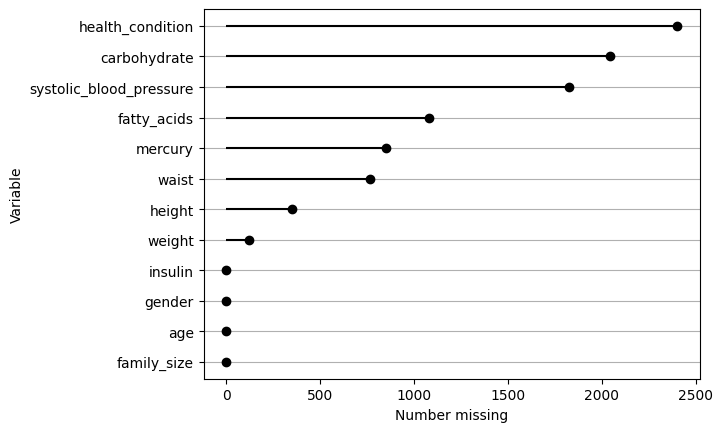

In [8]:
nhanes_grupo_3.missing.missing_variable_plot()

Se ve mas graficamente las columnas con datos faltantes. A excepcion de family_size, age, gender e insulin todas las columnas presentan datos nulos

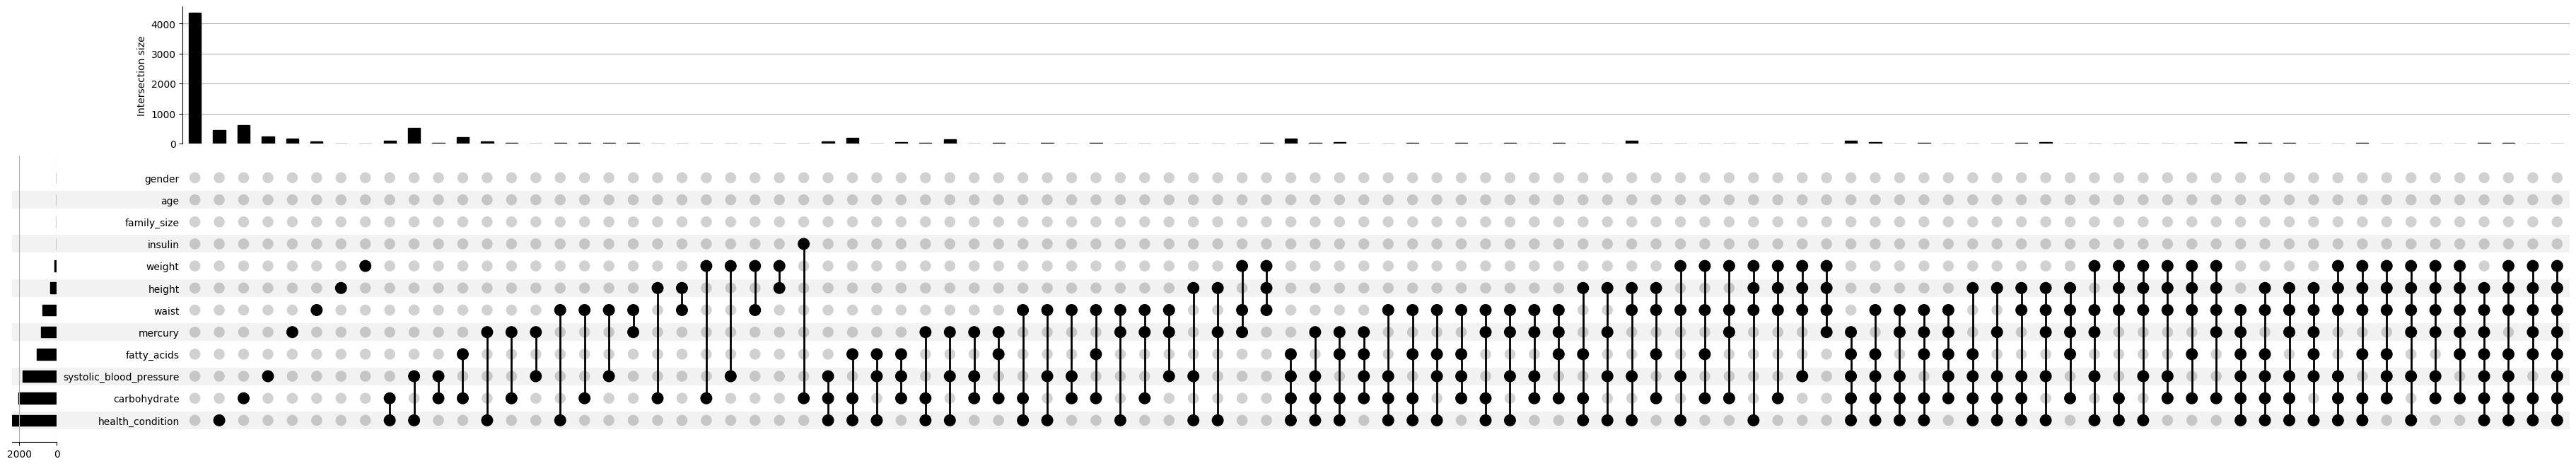

In [9]:
nhanes_grupo_3.missing.missing_upsetplot(variables = None)
plt.show()

### Con el upset plot se logra apreciar mas cosas:
1. Hay muchas variables en donde un dato faltante se puede relacionar con otro faltante. Por ejemplo, 'fatty_acids' nunca aparece nulo por si solo. Siempre que falta un dato en esta columna, falta un dato en otra

2. Continuando con esta variable, se logra apreciar que, cuando falta esta variable, tambien suele faltar el dato en la columna 'carbohydrate'. Para mejor visualizacion, se hace un mapa de calor

NOTA: No se hace "Matrix" ni "Bar" porque se identifica mejor con el upset plot

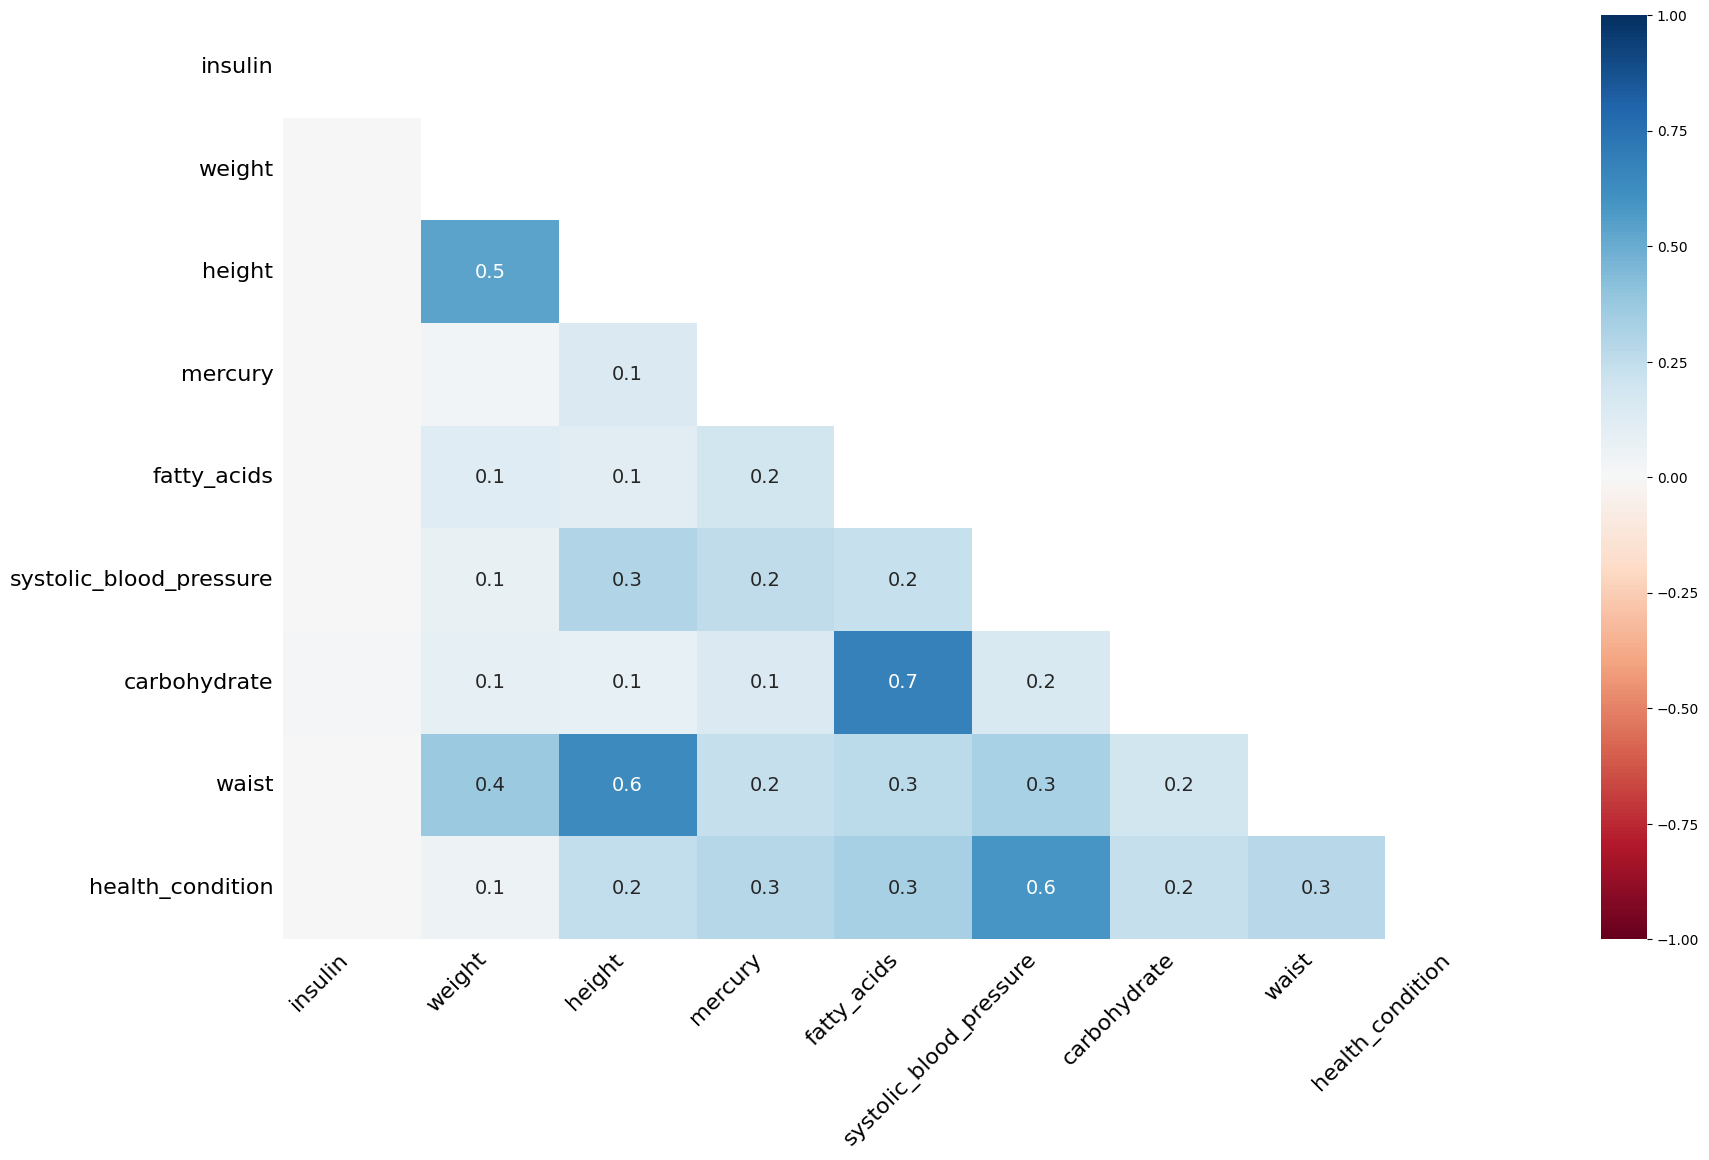

In [10]:
missingno.heatmap(nhanes_grupo_3)
plt.show()

De acuerdo al mapa de calor, se ve que hay una correlacion fuerte (o cercana a fuerte) entre 'carbohydrate' y 'fatty_acids', comprobando la suposicion. Otras correlaciones a resaltar pueden ser entre 'systolic_blood_pressure' y 'health_condition' y entre 'waist' y 'height', que presentan una correlacion moderada

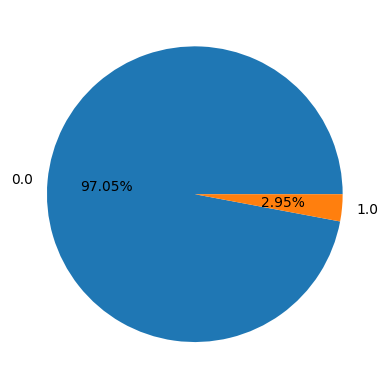

In [11]:
plt.pie(x = nhanes_grupo_3.insulin.value_counts(), labels = nhanes_grupo_3.insulin.value_counts().index, autopct='%0.2f%%')
plt.show()

La columna se llamaba originalmente 'taking_insulin_now', por lo que es booleana (1 es Si y 0 es No)

In [12]:
def summary_of_columns(df):
    summary = pd.DataFrame({
        'Non-Null Count': df.notnull().sum(),
        'Null Count': df.isnull().sum(),
        'Zero Count': (df == 0).sum(),
        'NaN Count': df.isna().sum()
    })
    
    summary['Total Count'] = len(df)
    summary['Percent Null'] = (summary['Null Count'] / summary['Total Count']) * 100
    summary['Percent Zero'] = (summary['Zero Count'] / summary['Total Count']) * 100
    summary['Percent NaN'] = (summary['NaN Count'] / summary['Total Count']) * 100
    
    return summary

# Usar la función con tu DataFrame
summary = summary_of_columns(nhanes_grupo_3)
print(summary)

                         Non-Null Count  Null Count  Zero Count  NaN Count  \
family_size                        8366           0           0          0   
age                                8366           0           0          0   
gender                             8366           0           0          0   
insulin                            8365           1        8118          1   
weight                             8242         124           0        124   
height                             8016         350           0        350   
mercury                            7513         853           0        853   
fatty_acids                        7285        1081           0       1081   
systolic_blood_pressure            6538        1828           0       1828   
carbohydrate                       6323        2043           0       2043   
waist                              7601         765           0        765   
health_condition                   5964        2402           0 

De aca se puede concluir que los datos faltantes son explicitos, ya que son directamente datos faltantes (NaN), y como tal no hay ceros aparte de la columna insulin, en donde estos ceros tienen sentido

Ahora se va a proceder a preparar los datos para la imputacion, transformando todas las columnas de tipo object

In [13]:
nhanes_grupo_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8366 entries, 93703.0 to 102956.0
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   family_size              8366 non-null   object 
 1   age                      8366 non-null   float64
 2   gender                   8366 non-null   object 
 3   insulin                  8365 non-null   float64
 4   weight                   8242 non-null   float64
 5   height                   8016 non-null   float64
 6   mercury                  7513 non-null   float64
 7   fatty_acids              7285 non-null   float64
 8   systolic_blood_pressure  6538 non-null   float64
 9   carbohydrate             6323 non-null   float64
 10  waist                    7601 non-null   float64
 11  health_condition         5964 non-null   object 
dtypes: float64(9), object(3)
memory usage: 849.7+ KB


In [14]:
for column in nhanes_grupo_3.columns:
    unique_values = nhanes_grupo_3[column].unique()
    print(f"Unique values in {column}: {unique_values}")


Unique values in family_size: ['5' '4' '1' '7 or more people in the Family' '2' '3' '6']
Unique values in age: [ 2. 66. 18. 13. 75. 56. 67. 54. 71. 61. 22. 45.  1. 60. 64.  5.  9. 70.
 53. 42. 57. 20. 72. 11. 52.  8. 26. 10. 25.  7. 73. 63. 55. 44. 74. 40.
 19. 36. 80.  6.  3. 69. 41. 47. 32. 46. 21. 34. 31. 12. 62. 59. 14. 24.
 16. 58. 68. 38. 48. 35. 50. 28. 29. 43. 76. 37. 30. 27. 15. 39. 49. 33.
 23. 79.  4. 17. 78. 77. 51. 65.]
Unique values in gender: ['Female' 'Male']
Unique values in insulin: [ 0.  1. nan]
Unique values in weight: [ 13.7  13.9  79.5 ... 118.2 108.6 129.2]
Unique values in height: [ 88.6  94.2 158.3 ... 133.1  96.8  82.5]
Unique values in mercury: [  nan  0.47  1.07 10.64  0.2  15.23  0.41  0.53  1.24  2.13  4.41  0.36
  2.28  0.29  0.73  0.48  1.5   0.44  1.51  0.98  2.14  0.5   0.37  5.05
  0.35  0.84  1.53  2.92  1.43  0.57  0.97  1.13  2.84  0.68  0.51  0.7
  0.45  0.77  0.66  1.4   0.59  0.56  1.41  1.84  0.61  0.31  2.38  0.33
  1.82  1.21  0.99  0.75  1.2

In [17]:
nhanes_grupo_3['family_size'] = nhanes_grupo_3['family_size'].replace('7 or more people in the Family', 7)
nhanes_grupo_3['family_size'] = nhanes_grupo_3['family_size'].astype('float64')

nhanes_grupo_3['gender'] = nhanes_grupo_3['gender'].replace({'Female': 0, 'Male': 1})
nhanes_grupo_3['gender'] = nhanes_grupo_3['gender'].astype('float64')

nhanes_grupo_3['health_condition'] = nhanes_grupo_3['health_condition'].replace({
    'Poor?': 1,
    'Fair or': 2,
    'Good': 3,
    'Very good': 4,
    'Excellent': 5
})
nhanes_grupo_3['health_condition'] = nhanes_grupo_3['health_condition'].astype('float64')

Se transformaron los datos de la siguiente forma:
- En 'family_size' se convirtio la entrada de "7 or more people in the Family" a solamente 7
- En 'gender' se convirtio "Female" a 0 y "Male" a 1
- En 'health_condition' se convirtio "Poor?" a 1, "Fair or" a 2, "Good" a 3, "Very good" a 4 y "Excellent" a 5

Finalmente, todas las columnas pasaron a ser de tipo float64

In [19]:
for column in nhanes_grupo_3.columns:
    unique_values = nhanes_grupo_3[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in family_size: [5. 4. 1. 7. 2. 3. 6.]
Unique values in age: [ 2. 66. 18. 13. 75. 56. 67. 54. 71. 61. 22. 45.  1. 60. 64.  5.  9. 70.
 53. 42. 57. 20. 72. 11. 52.  8. 26. 10. 25.  7. 73. 63. 55. 44. 74. 40.
 19. 36. 80.  6.  3. 69. 41. 47. 32. 46. 21. 34. 31. 12. 62. 59. 14. 24.
 16. 58. 68. 38. 48. 35. 50. 28. 29. 43. 76. 37. 30. 27. 15. 39. 49. 33.
 23. 79.  4. 17. 78. 77. 51. 65.]
Unique values in gender: [0. 1.]
Unique values in insulin: [ 0.  1. nan]
Unique values in weight: [ 13.7  13.9  79.5 ... 118.2 108.6 129.2]
Unique values in height: [ 88.6  94.2 158.3 ... 133.1  96.8  82.5]
Unique values in mercury: [  nan  0.47  1.07 10.64  0.2  15.23  0.41  0.53  1.24  2.13  4.41  0.36
  2.28  0.29  0.73  0.48  1.5   0.44  1.51  0.98  2.14  0.5   0.37  5.05
  0.35  0.84  1.53  2.92  1.43  0.57  0.97  1.13  2.84  0.68  0.51  0.7
  0.45  0.77  0.66  1.4   0.59  0.56  1.41  1.84  0.61  0.31  2.38  0.33
  1.82  1.21  0.99  0.75  1.28  1.05  1.11  0.96  1.02  1.42  1.44  3.62
  

### Imputacion Simple

<Axes: xlabel='height', ylabel='weight'>

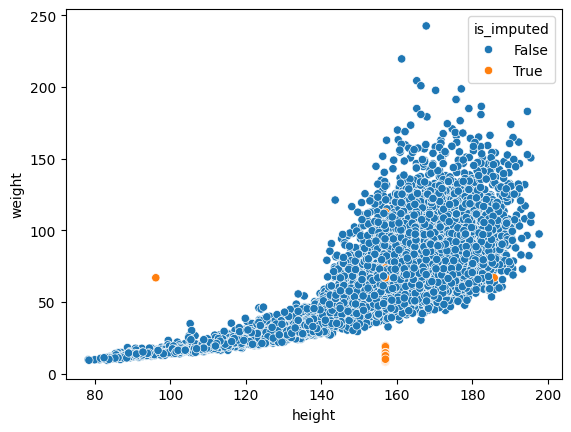

In [24]:
imputador_simple = sklearn.impute.SimpleImputer(strategy='mean')
imputador_simple.fit(nhanes_grupo_3.select_dtypes(include=['float64']))
nhanes_grupo_3_imputado = nhanes_grupo_3.copy()
nhanes_grupo_3_imputado[nhanes_grupo_3_imputado.select_dtypes(include=['float64']).columns] = imputador_simple.transform(nhanes_grupo_3_imputado.select_dtypes(include=['float64']))
redondeo = ['family_size', 'age', 'gender', 'health_condition']
nhanes_grupo_3_imputado[redondeo] = nhanes_grupo_3_imputado[redondeo].round()
nhanes_grupo_3.select_columns('height', 'weight').missing.bind_shadow_matrix(True, False, suffix = '_imp').assign(
    height = lambda df: df.height.fillna(value = df.height.mean().round()),
    weight = lambda df: df.weight.fillna(value = df.weight.mean().round())).missing.scatter_imputation_plot(x = 'height',
                                                                                                            y = 'weight')

Los valores imputados parecen ser escasos, y no se acomodan correctamente al resto de datos

### Imputacion Por Vecinos Cercanos

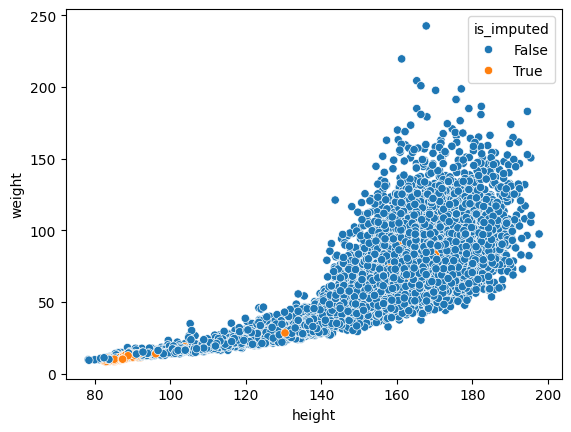

In [39]:
nhanes_grupo_3_knn_imputado = nhanes_grupo_3.copy()
columnas_numericas = nhanes_grupo_3_knn_imputado.select_dtypes(include=['float64']).columns
knn_imputador = sklearn.impute.KNNImputer(n_neighbors=5)
nhanes_grupo_3_knn_imputado[columnas_numericas] = knn_imputador.fit_transform(nhanes_grupo_3_knn_imputado[columnas_numericas])
columns_to_round = ['family_size', 'age', 'gender', 'health_condition']
nhanes_grupo_3_knn_imputado[columns_to_round] = nhanes_grupo_3_knn_imputado[columns_to_round].round()
nhanes_grupo_3_knn_imputado.head()

knn_imputer_shadow_matrix = pd.concat([nhanes_grupo_3_knn_imputado,
                                       nhanes_grupo_3.missing.create_shadow_matrix(True, False, suffix = '_imp',
                                                                              only_missing = True)], axis=1)
knn_imputer_shadow_matrix.missing.scatter_imputation_plot(x = 'height', y = 'weight')
plt.show()

Los valores imputados se acomodan mejor que con la imputacion simple, pero siguen siendo mas bien escasos

### Imputacion MICE - Regresion Lineal

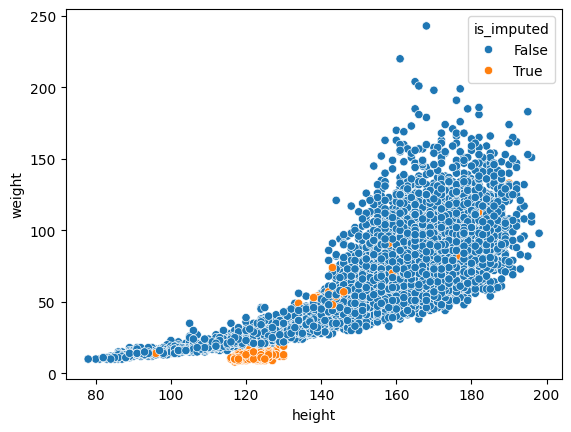

In [43]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=LinearRegression(),
                                initial_strategy='mean',
                                max_iter=10)
nhanes_miceRL_df = pd.DataFrame(mice_imputer.fit_transform(nhanes_grupo_3).round(),
                              columns=nhanes_grupo_3.columns,
                              index=nhanes_grupo_3.index)
mice_imputer_shadow_matrix = pd.concat([nhanes_miceRL_df, 
                                        nhanes_grupo_3.missing.create_shadow_matrix(True, False,
                                                                                     suffix='_imp',
                                                                                     only_missing=True)], axis=1)
mice_imputer_shadow_matrix.missing.scatter_imputation_plot(x='height', y='weight')
plt.show()

Aca fue imputada una mayor cantidad de datos, pero estan un poco alejados de la tendencia de estos

### Imputacion MICE – Arbol de Decision

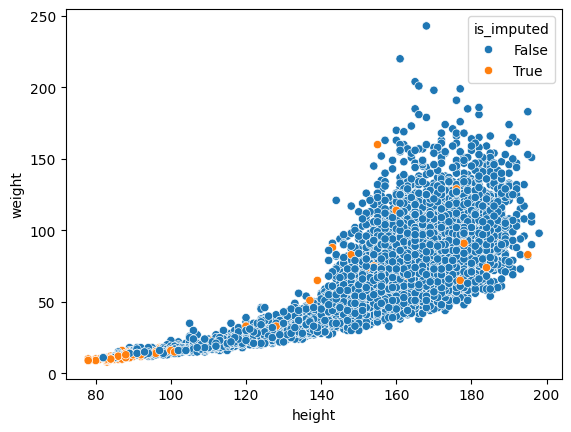

In [44]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=DecisionTreeRegressor(),
                                initial_strategy='mean',
                                max_iter=10)
nhanes_miceDTR_df = pd.DataFrame(mice_imputer.fit_transform(nhanes_grupo_3).round(),
                              columns=nhanes_grupo_3.columns,
                              index=nhanes_grupo_3.index)
mice_imputer_shadow_matrix = pd.concat([nhanes_miceDTR_df, 
                                        nhanes_grupo_3.missing.create_shadow_matrix(True, False,
                                                                                     suffix='_imp',
                                                                                     only_missing=True)], axis=1)
mice_imputer_shadow_matrix.missing.scatter_imputation_plot(x='height', y='weight')
plt.show()

En este metodo hay una buena cantidad de datos imputados y relativamente bien acomodados con respecto al resto.

### Imputacion MICE – Bosque Aleatorio

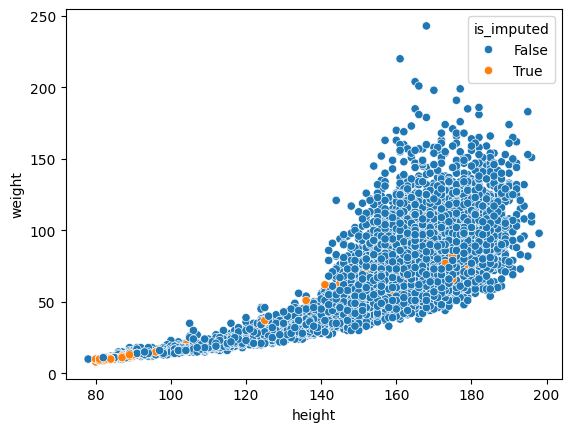

In [45]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=RandomForestRegressor(),
                                initial_strategy='mean',
                                max_iter=10)
nhanes_miceRFR_df = pd.DataFrame(mice_imputer.fit_transform(nhanes_grupo_3).round(),
                              columns=nhanes_grupo_3.columns,
                              index=nhanes_grupo_3.index)
mice_imputer_shadow_matrix = pd.concat([nhanes_miceRFR_df, 
                                        nhanes_grupo_3.missing.create_shadow_matrix(True, False,
                                                                                     suffix='_imp',
                                                                                     only_missing=True)], axis=1)
mice_imputer_shadow_matrix.missing.scatter_imputation_plot(x='height', y='weight')
plt.show()

### Imputacion MICE – Red Neuronal Perceptron

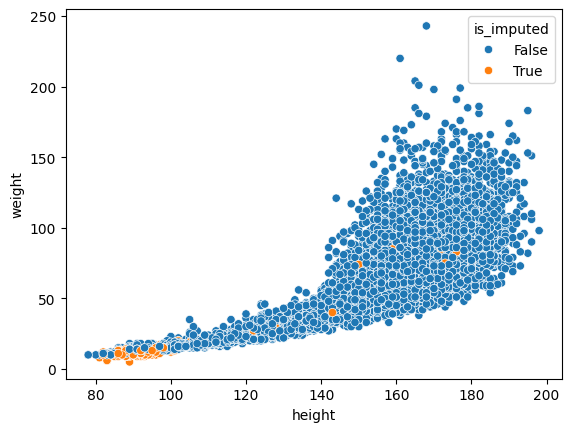

In [46]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=MLPRegressor(max_iter=1000),
                                initial_strategy='mean',
                                max_iter=10)
nhanes_miceRNP_df = pd.DataFrame(mice_imputer.fit_transform(nhanes_grupo_3).round(),
                              columns=nhanes_grupo_3.columns,
                              index=nhanes_grupo_3.index)
mice_imputer_shadow_matrix = pd.concat([nhanes_miceRNP_df, 
                                        nhanes_grupo_3.missing.create_shadow_matrix(True, False,
                                                                                     suffix='_imp',
                                                                                     only_missing=True)], axis=1)
mice_imputer_shadow_matrix.missing.scatter_imputation_plot(x='height', y='weight')
plt.show()

Estos ultimos dos metodos muestran una muy buena cantidad de datos imputados y estos se comportan acorde con el resto de datos.

### Conclusion

Considero que los ultimos dos metodos RandomForestRegressor y MLPRegresssor acomodan los datos imputados de mejor manera. Aun asi, estos metodos son bastante exigentes computacionalmente, por lo que, si se necesita realizar una imputacion rapida y eficaz, utilizaria el metodo de DecissionTreeRegressor. El resto de metodos de imputacion no mostraron una acomodacion de datos imputados lo suficientemente buena como para considerarlos en caso de necesitar un analisis riguroso y certero de estos.